# <font color='#2B4865'>**Hugging Face 🤗 Transformers Tutorial I**</font>

---
### Natural Language Processing
Date: Dec 21, 2022

Author: Lorena Calvo-Bartolomé (lcalvo@pa.uc3m.es)

Version 1.0

---
This notebook is based on the [Hugging Face course](https://huggingface.co/course/chapter1/1), documentation available at the Hugging Face website and  [CS224n](https://web.stanford.edu/class/cs224n/)'s Hugging Face Transformers Tutorial session by Ben Newman.

It constitutes the first out of three tutorial notebooks on the usage of Hugging Face libraries as well as its application for solving a series of NLP tasks.

This notebook provides an introduction to the Hugging Face 🤗 Python library. In particular, its **goals** are:

*  To establish a common pattern for performing inference with Hugging Face Transformer models
*  To revise the specific fine-tuning example on the task of Sentiment Analysis

---

<font color='#E0144C'>**For this notebook's execution, we highly encourage you to use Google Colaboratory. While for the inference part it is not necessary, you will highly speed up the execution if you make use of a GPU. For doing so, follow the following steps:**</font>

<font color='#E0144C'>**1. Connect to hosted runtime**</font>

<font color='#E0144C'>**2. Enable GPU setting by clicking Edit -> Notebook Settings -> Select GPU in Hardware Acceleration Tab -> Save**</font>

### PRÁCTICA 4.2 - PROCESAMIENTO DEL LENGUAJE NATURAL - MASTER EN INTELIGENCIA ARTIFICIAL APLICADA

### JOSÉ LORENTE LÓPEZ - DNI: 48842308Z

## <font color='#2B4865'>Installing necessary packages, imports and auxiliary functions</font>

In [1]:
# Importamos las librerías necesarias para el desarrollo de la práctica

# Install necessary packages
import importlib, os

necessary_packages = ['transformers[sentencepiece]', 'datasets', 'gradio', 'colored', 'wikipedia', 'evaluate', 'nltk', 'rouge_score']
def import_missing(packages):
  for p in packages:
    try:
      mod = importlib.import_module(p)
      print(f"Package {p} already installed!")
      packages.remove(p)
    except ModuleNotFoundError:
      print(f"Installing package {p}")
      with open("requirements.txt", 'w') as f:
        f.write("\n".join(str(i) for i in packages))
  if os.path.isfile("requirements.txt"):
    %pip install --quiet -r "requirements.txt"

import_missing(necessary_packages)

Installing package transformers[sentencepiece]
Installing package datasets
Installing package gradio
Installing package colored
Installing package wikipedia
Installing package evaluate
Package nltk already installed!
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/loca

In [ ]:
# Librerías más generales 
import os
import numpy as np
import pandas as pd
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import scipy
from colored import fore, back, style
import gradio as gr
import torch
import json
import random
from collections import defaultdict
import nltk
nltk.download("punkt")

# Figures plotted inside the notebook
%matplotlib inline 
# High quality figures
%config InlineBackend.figure_format = 'retina' 
# Figures style
plt.style.use('seaborn-whitegrid')
sns.set_style("darkgrid")
sns.color_palette("deep")
# Figues size
plt.rcParams['figure.figsize'] = [8, 6]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',module='gradio')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# For fancy table Display
%load_ext google.colab.data_table

In [ ]:
# Auxiliary funcion to print Trasnformer encodings
def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

We are going to save all the files in this notebook generated into Drive. Fill the variable ``path_to_folder`` in the next with your Drive's folder in which you want to save the files.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_folder = '/content/drive/MyDrive/Cosas/NLP_IA/Cosas_LAB_4/P3'  # UPDATE THIS ACCORDING TO WHERE YOU WANT TO SAVE THE FILES!!!!

# Change to assignment directory
os.chdir(path_to_folder) 

## <font color='#2B4865'>**0. Introduction**
---
</font>

### <font color='#2B4865'>*0.1. Hugging Face*</font>

As we have seen in class, Transformer models have become state-of-the-art for NLP to solve a wide range of tasks. In practice, we will rarely train a Transformer model from scratch, as they tend to be very large, thus requiring time, money, and lots of data to train fully. Instead, we will want to start with a pre-trained model and fine-tune it with our specific dataset if required.

[Hugging Face](https://huggingface.co/) (🤗) is the best resource for pre-trained transformers. Among other things, it provides:

*   APIs and tools to easily download and train state-of-the-art pretrained models, as well as pipelines for carrying out common NLP tasks, in the [Transformers library](https://huggingface.co/docs/transformers/index).
*   State-of-the-art tokenizers, optimized for both research and production are also used in Transformers in the [Tokenizers library](https://huggingface.co/docs/tokenizers/index).
*   Datasets and metrics in the [Datasets library](https://huggingface.co/docs/datasets/index).

It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the **PyTorch** versions here).

Hoy por hoy los transformers es una parte fundamental del estado del arte de los modelos NLP. Rara vez se entrenan desde 0 (suelen ser modelos masivos y el gasto es muy exagerado), es por ello que se suelen usar modelos pre-entrenados y se les tunea para enfocarlos a nuestra tarea con nuestro dataset específico.

La mejor librería para esta tarea es "Hugging face". Proporciona modelos pre-entrenados y una facil manera de entrenarlos. Tokenizadores, datasets, ...

Se puede usar con Pytorch (lo que usaremos), tensorflow y flax.

### <font color='#2B4865'>*0.2. NLP tasks overview*</font>

In the series of notebooks "Hugging Face Transformers Tutorial" I, II & III, we will learn how to approach via Hugging Face the tasks of:

*   **Sentiment Analysis**
*   **Extractive Question Answering**
*   **Summarization**
*   **Text Generation**

Even when we are just going to cover the above-mentioned tasks, bear in mind that many others can be addressed through Hugging Face.

In any case, we will use a different Transformer architecture depending on the task we aim to solve. The following table summarizes the most common tasks that can be approached with either an Encoder, Decoder, or a full Encoder-Decoder architecture:

<table><thead><tr><th><font color='#256D85'>Model</font></th><th><font color='#256D85'>Examples</font></th><th><font color='#256D85'>Tasks</font></th></tr></thead><tbody><tr><td><b>ENCODER</b></td><td>ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa</td><td>Sentence classification, named entity recognition, extractive question answering</td></tr><tr><td><b>DECODER</b></td><td>CTRL, GPT, GPT-2, Transformer XL</td><td>Text generation</td></tr><tr><td><b>ENCODER-DECODER</b></td><td>BART, T5, Marian, mBART</td><td>Summarization, translation, generative question answering</td></tr></tbody></table>

In the following, we will attempt to solve the aforementioned tasks first through inference, and then, via fine-tuning. We will start by presenting a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis, and then we will benefit from such a pattern to work out the other two tasks.

En los 3 tutoriales de hugging face abarcaremos usando las libreríua el uso de modelos pre-entrenaods para analisis de sentimientos, question answering, resumen de textos y generación de texto. (aunque se podrían abarcar muchas otras; veamos una tabla con los posibles modelos a crear en función del bloque de transformer que utilicemos):

<table><thead><tr><th><font color='#256D85'>Model</font></th><th><font color='#256D85'>Examples</font></th><th><font color='#256D85'>Tasks</font></th></tr></thead><tbody><tr><td><b>ENCODER</b></td><td>ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa</td><td>Sentence classification, named entity recognition, extractive question answering</td></tr><tr><td><b>DECODER</b></td><td>CTRL, GPT, GPT-2, Transformer XL</td><td>Text generation</td></tr><tr><td><b>ENCODER-DECODER</b></td><td>BART, T5, Marian, mBART</td><td>Summarization, translation, generative question answering</td></tr></tbody></table>

Primero resolveremos el modelo con inference y luego con modelos pre-entrenados




## <font color='#2B4865'>**1. Sentiment Analysis**
---
</font>

As we saw in Block I, **Sentiment analysis** is an NLP technique that identifies the polarity of a given text. There are different forms of sentiment analysis, but one of the most widely used techniques labels data as positive, negative, and neutral.

##### <font color='#2B4865'>**Demo**</font>

In the next cell, you can test a Sentiment analysis system built with [Gradio](https://gradio.app/) and a 🤗 fine-tuned model [from the Hub](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis). You can try it out by inserting any sentence or clicking on the example ones.

Veamos un ejemplo de un modelo (ya creado) de clasificación de frases por sentimiento creado con gradio y la librería hugging-face (con los típicos labels pos, neg or neut).



In [ ]:
examples = [
    ["I like you. I love you"],
    ["You are the worst!!"]
]


gr.Interface.load("huggingface/finiteautomata/bertweet-base-sentiment-analysis", 
                  inputs = "text", 
                  outputs = ['text'],
                  title = 'Sentiment Analysis', 
                  examples=examples,
                  description="Get Sentiment Negative/Positive for the given input").launch()

Fetching model from: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

##### <font color='#2B4865'>**Architecture for approaching the task**</font>

**Sentiment Analysis** is not more than a use case of the general task named **Token classification**, that is, any problem that can be formulated as "*attributing a label to each token in a sentence*". Other types of Token Classification tasks include **Named entity recognition (NER)** and **Part-of-speech tagging (POS)**, among others. All of them are approached via **BERT-like** models.

##### <font color='#2B4865'>**Evaluation metrics**</font>

Same as we did in the Text Vectorization notebooks, we will be analyzing our Sentiment Analysis task based on the **accuracy**, that is the proportion of correct predictions among the total number of cases processed:

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$

Even though we will be using accuracy, note that there exist other metrics for token classification tasks such as the **F1-score**.

Primero usaremos modelos tal cual y luego ajustaremos modelos a nuestros propios datasets con fine-tuning

### <font color='#2B4865'>*1.1. Inference*</font>

#### <font color='#2B4865'>*1.1.1. Transformers pipelines*</font>

La librería HF, proporciona pipelines para resolver ciertas tareas.

Estas pipelines se forman por: tokenizador (para pasar de texto en crudo a texto limpio tokenizado) + modelo (para ejecutar la tarea; en este caso uno que dado una entraga haga la predicción del sentimiento) + postprocesado (bloque opcional para mejorar los resultados del modelo).

Toda la pipeline se empaqueta en un objeto fácil de usar. 

Como tal podemos usar el objeto piopeline() (el cual engloba dentro todos los tipos de pipelines y se especifica el que usar como atributo en función de la tarea a resolver), o usamos pipeline específicos Ej: AudioClassificationPipeline.



The 🤗 ``Transformers`` library provides ``pipelines`` to solve specific tasks. A **pipeline** consists of:

*   a **tokenizer** in charge of mapping raw textual input to tokens
*   a **model** to make predictions from the inputs
*   some (optional) **postprocessing** for enhancing model’s output

all of them packaged together into an easy-to-use and configurable object.

<br><center><img src="https://drive.google.com/uc?id=1dTZTRdLRAWWR_8yJf-l7DzKphj7MW9wB" width="60%"></center><br>

Pipelines are an easy way to use models for inference since they are **intended to be used without fine-tuning**. They are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks.

There are **two categories of pipeline abstractions** to be aware of: the ``pipeline()`` which is the most powerful object encapsulating all other pipelines, and other **task-specific pipelines**. Some examples of the latter include:

```python
AudioClassificationPipeline
AutomaticSpeechRecognitionPipeline
ConversationalPipeline
FeatureExtractionPipeline
...
```

**NOTE**: You can create a pipeline without specifying any model. In this case, the default checkpoint associated with the pipeline being instantiated will be used.

For more information about pipelines, you can check the [Hugging Face Pipelines Docs](https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/pipelines#transformers.pipeline).

Let's see how to exploit these pipelines for our Sentiment Analysis task.

The **first step** is to find a model on [the hub](https://huggingface.co/models). Here, we will be using [``siebert/sentiment-roberta-large-english``](https://huggingface.co/siebert/sentiment-roberta-large-english), a fine-tuned checkpoint of [RoBERTa-large](https://arxiv.org/pdf/1907.11692.pdf) for sentiment classification.

Once we have the model we are going to use, we can create our Sentiment Analysis pipeline and use it to predict the polarity of any sentence.

Lo pirmero es encontrar en el hub de modelos de HF, un modelo acorde a la tarea. Usaremos el de roberta para clasificación de sentimientos.

Metemos el modelo en un objeto pipeline y con esto le podemos meter frases tal cual y nos dará una predicción del sentimiento asociado a la misma.

In [ ]:
checkpoint_name = "siebert/sentiment-roberta-large-english"

from transformers import pipeline

# Create a TextClassificationPipeline object
sentiment_analysis = pipeline("sentiment-analysis", model=checkpoint_name)     

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Predict the sentiment of any sentence
sentences = ["I'm excited to keep learning about Transformers!",
             "I hate this so much!",
             " This is exciting!"]
sentiment_analysis(sentences)

[{'label': 'POSITIVE', 'score': 0.9988435506820679},
 {'label': 'NEGATIVE', 'score': 0.9994413256645203},
 {'label': 'POSITIVE', 'score': 0.9983626008033752}]

Within the pipeline, there are two objects that are initialized, a **tokenizer** and a **model**. We can mimic step by step the process carried out by the pipeline for the classification of the sentiment:

Podemos ver paso a paso lo que hacen los dos objetos del pipeline (tokenizador + modelo).

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name)

# Tokenize text inputs
tokenized_inputs = tokenizer(sentences[0], return_tensors="pt")

# Pass tokenized inputs through the Transformer model
outputs = model(**tokenized_inputs)

# Get predictions
labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)

print(fore.LIGHT_BLUE + style.BOLD + "Inputs:" + style.RESET)
print(sentences[0]+"\n")

print(fore.LIGHT_BLUE + style.BOLD + "Tokenized Inputs:" + style.RESET)
print_encoding(tokenized_inputs)
print()

print(fore.LIGHT_BLUE + style.BOLD + "Model Outputs:" + style.RESET)
print(outputs)
print()

print(f"The prediction is {labels[prediction]}")

Inputs:
I'm excited to keep learning about Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,   489,  2239,    59, 34379,   328,
             2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7951,  2.9662]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


#### <font color='#2B4865'>*1.1.2. Tokenizers*</font>

Pretrained models are implemented along with tokenizers that are used to preprocess their inputs. Tokenizers take raw strings or a list of strings and output what are effectively dictionaries that contain the model inputs.

We can access 🤗 Tokenizers either with the Tokenizer class specific to the model (here RoBERTa) or with the ``AutoTokenizer`` class, and its ``from_pretrained()`` method. **Fast Tokenizers** are written in Rust, while their slow versions are written in Python. By doing so, **the tokenizer will preprocess the inputs in exactly the same way as when the model was pretrained**.

In [ ]:
from transformers import RobertaTokenizer, RobertaTokenizerFast, AutoTokenizer

tokenizer = RobertaTokenizer.from_pretrained(checkpoint_name)    
print(fore.LIGHT_BLUE + style.BOLD + "Model-specific tokenizer class" + style.RESET)               
print(tokenizer)
print()

print(fore.LIGHT_BLUE + style.BOLD + "Fast Model-specific tokenizer class" + style.RESET)
tokenizer = RobertaTokenizerFast.from_pretrained(checkpoint_name)               
print(tokenizer)
print()

print(fore.LIGHT_BLUE + style.BOLD + "AutoTokenizer class -> defaults to Fast!" + style.RESET)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)                      
print(tokenizer)

Model-specific tokenizer class
PreTrainedTokenizer(name_or_path='siebert/sentiment-roberta-large-english', vocab_size=50265, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})

Fast Model-specific tokenizer class
PreTrainedTokenizerFast(name_or_path='siebert/sentiment-roberta-large-english', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

AutoTokenizer class -> defaults to Fast!
PreTrainedTokenizerFast(name_or_path='siebert/sentiment-roberta-large-english', vocab_size=50265, model_max_len=512, is_fast=Tr

Once we have the tokenizer, we can directly pass our sentences to it and we will get back a **dictionary** that’s ready to feed to our model. The only thing left to do is to **convert the list of input IDs to tensors**, since Transformer models **only accept tensors as input**.

To specify the type of tensors we want to get back (PyTorch, TensorFlow, or plain NumPy), we use the ``return_tensors`` argument:

Una vez tenemos el tokenizer, le pasamos las frases y por cada una de ellas, nos devuelve una lista donde cada posición es acorde al index en el diccionario de la palabra de dicha posición en la frase.

Con "return_tensors" le indicamos si el tensor que nos devuelve debe ser pytorch, tensorflow o numpy.

In [ ]:
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
print_encoding(tokenized_inputs)

{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,   489,  2239,    59, 34379,   328,
             2],
        [    0,   100,  4157,    42,    98,   203,   328,     2,     1,     1,
             1],
        [    0,   152,    16,  3571,   328,     2,     1,     1,     1,     1,
             1]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])
}


**Tokenization** takes place in a **three-step process**:
1. Split the input into tokens (words, subwords, or symbols): ``tokenize()``
2. Map each token into an integer: ``convert_tokens_to_ids()``
3. Add additional inputs that may be useful to the model:
  *   **Padding.** Batching allows the model to work when you feed it multiple sentences, but this can lead to problems when we attempt to batch together two (or more) sentences that are of different lengths. Since we are working with tensors, we need them to be of rectangular shape. We solve this issue by padding our sentences so they all have the same length by adding a special word called the **padding token** to the sentences with fewer values.
A **tokenizer's padding token ID** can be found in ``tokenizer.pad_token_id``.
  *   **Attention masks.** They are tensors with the exact same shape as the input IDs tensor, filled with ``0s`` and ``1s``: ``1s`` indicate the corresponding tokens should **be attended to**, and ``0s`` indicate the corresponding tokens should **not be attended to** (i.e., they should be ignored by the attention layers of the model), e.g., the padding tokens should be ignored.
  *  **Special tokens.** When encoding an input string sequence, the tokenizer will add some special tokens. For the case of token classification, for example, it adds additional tokens ``[CLS]`` at the beginning and ``[SEP]`` at the end. This is because the model was pretrained with those, so to get the same results for inference we need to add them as well. Note that some models don’t add special words, or add different ones; models may also add these special words only at the beginning, or only at the end. In any case, the tokenizer knows which ones are expected and will deal with this for you. We can access these tokens as ``tokenizer.cls_token_id`` and ``tokenizer.sep_token_id``, respectively.

One last thing that we need to take into account when performing tokenization is the **limit to the lengths of the sequences we can pass the models** that are imposed by the Transformer model in use. Most models handle sequences of up to 512 or 1024 tokens and will crash when asked to process longer sequences. There are two solutions to this problem:

* Use a model with a longer supported sequence length.
* Truncate the sequences. We can truncate our sequences by specifying the parameter ``truncation=True``. Additionally, we can specify the maximum length after which sentences will be truncated with the ``max_length`` parameter.

**Steps 1 and 2** of the Tokenization process above described are normally named together as **encoding**, and its opposite
process is referred as **decoding** (``decode()``).

La tokenización son tres procesos: Dividir las palabras en tokens, convertir cada token en un entero (su posición en el diccionario) añadir inputs útiles para el modelo.

Alguna curiosa es el Attention_Mask (que tiene la misma length que la frase en tokens de entrada e indica al modelo que tokens debe prestarle atención y a cuales no)

In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]
print("cls: ", cls)
print("sep: ", sep)
print()

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(sentences[0])
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print(fore.LIGHT_BLUE + style.BOLD + "Start:                " + style.RESET, sentences[0])
print(fore.LIGHT_BLUE + style.BOLD + "Tokenize:             " + style.RESET, input_tokens)
print(fore.LIGHT_BLUE + style.BOLD + "Convert tokens to IDs:" + style.RESET, input_ids)
print(fore.LIGHT_BLUE + style.BOLD + "Add special tokens:   " + style.RESET, input_ids_special_tokens)
print(fore.LIGHT_BLUE + style.BOLD + "--------" + style.RESET)
print(fore.LIGHT_BLUE + style.BOLD + "decode:               " + style.RESET, decoded_str)
# NOTE that these steps don't create the attention mask nor add the special characters

cls:  [0]
sep:  [2]

Start:                 I'm excited to keep learning about Transformers!
Tokenize:              ['I', "'m", 'Ġexcited', 'Ġto', 'Ġkeep', 'Ġlearning', 'Ġabout', 'ĠTransformers', '!']
Convert tokens to IDs: [100, 437, 2283, 7, 489, 2239, 59, 34379, 328]
Add special tokens:    [0, 100, 437, 2283, 7, 489, 2239, 59, 34379, 328, 2]
--------
decode:                <s>I'm excited to keep learning about Transformers!</s>


In [ ]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(sentences[0])

print(fore.LIGHT_BLUE + style.BOLD + "Number of tokens:" + style.RESET, len(inputs))
print(fore.LIGHT_BLUE + style.BOLD + "Ids:" + style.RESET, inputs.ids)
print(fore.LIGHT_BLUE + style.BOLD + "Tokens:" + style.RESET, inputs.tokens)
print(fore.LIGHT_BLUE + style.BOLD + "Special tokens mask:" + style.RESET, inputs.special_tokens_mask)

Number of tokens: 11
Ids: [0, 100, 437, 2283, 7, 489, 2239, 59, 34379, 328, 2]
Tokens: ['<s>', 'I', "'m", 'Ġexcited', 'Ġto', 'Ġkeep', 'Ġlearning', 'Ġabout', 'ĠTransformers', '!', '</s>']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
# We can pass multiple strings into the tokenizer and pad them as we need
model_inputs = tokenizer(["Situps are a terrible way to end your day.",
                          "She lived on Monkey Jungle Road and that seemed to explain all of her strangeness." +\
                          "There is no better feeling than staring at a wall with closed eyes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(fore.LIGHT_BLUE + style.BOLD + "Pad token:" + style.RESET, tokenizer.pad_token)
print(fore.LIGHT_BLUE + style.BOLD + "Pad token id:" + style.RESET, tokenizer.pad_token_id)
print(fore.LIGHT_BLUE + style.BOLD + "Padding:" + style.RESET)
print_encoding(model_inputs)

Pad token: <pad>
Pad token id: 1
Padding:
{
    input_ids:
        tensor([[    0, 44683,  4489,    32,    10,  6587,   169,     7,   253,   110,
           183,     4,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1],
        [    0,  2515,  3033,    15, 34546, 29553,  1214,     8,    14,  2551,
             7,  3922,    70,     9,    69, 31083, 14186,     4,   970,    16,
           117,   357,  2157,    87, 19311,    23,    10,  2204,    19,  1367,
          2473,     4,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [ ]:
# We can also decode a whole batch at once:
print(fore.LIGHT_BLUE + style.BOLD + "Batch Decode:" + style.RESET)
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print(fore.LIGHT_BLUE + style.BOLD + "Batch Decode: (no special characters)" + style.RESET)
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['<s>Situps are a terrible way to end your day.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', '<s>She lived on Monkey Jungle Road and that seemed to explain all of her strangeness.There is no better feeling than staring at a wall with closed eyes.</s>']

Batch Decode: (no special characters)
['Situps are a terrible way to end your day.', 'She lived on Monkey Jungle Road and that seemed to explain all of her strangeness.There is no better feeling than staring at a wall with closed eyes.']


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (for the Fast Tokenizers).

#### <font color='#2B4865'>*1.1.3. Models*</font>

##### <font color='#2B4865'>**Configuration objects**</font>

We can check the **configuration of a Transformer model** by loading its associated **configuration object**, which contains many **attributes** that were used to build the model. 

We could **create a model from the default configuration**, but it gets initialized with random values. While the model can be used in this state, it will output nonsense, as it needs to be trained first.

Un modelo NLP transformer tiene una configuración dada. Podemos verla obteniendo el objeto config del mismo.

Al generar el modelo le podemos pasar el objeto config modificado por nosotros para adaptarlo a nuestras necesidades. Podemos no pasarle nada pero el archivo config se inicializa con valores aleatorios.

Tras esto el modelo se podrá utilizar pero, lógicamente, necesitamos entrenarlo para que de resultados con sentido.

In [ ]:
from transformers import RobertaConfig, RobertaModel

# Building the config
config = RobertaConfig()

# Building the model from the config
model = RobertaModel(config)

print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



##### <font color='#2B4865'>**Loading pretrained models**</font>

As an alternative to loading models from their configuration object, we can initialize them in a very similar way as we did with tokenizers. We can either use the model class specific to our model or an ``AutoModel`` class. Both of them also have a ``from_pretrained()`` method. 

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint_name)

Some weights of the model checkpoint at siebert/sentiment-roberta-large-english were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

The model object we have instantiated in the former cell contains only the **base Transformer module: given some inputs, it outputs what we will call hidden states, also known as features**. For each model input, we will retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model. While these hidden states can be useful on their own, they are usually inputs to another part of the model, known as the **head**. We can **perform different tasks with the same Transformer architecture**, but each of these tasks will have a **different head associated** with it.


##### <font color='#2B4865'>**Transformer module output**</font>

The vector output by the Transformer module is usually large. It generally has **three dimensions:**
*  **Batch size:** The number of sequences processed at a time ($2$ in our ``sentences`` example).
*  **Sequence length:** The length of the numerical representation of the sequence ($11$ in our ``sentences`` example).
*  **Hidden size:** The vector dimension of each model input.

It is said to be **"high dimensional"** because of the last value. The hidden size can be very large ($768$ is common for smaller models, and in larger models this can reach $3072$ or more).

In [ ]:
outputs = model(**tokenized_inputs)

The outputs of Transformers models behave like ``namedtuples`` or ``dictionaries``. We can access the elements **by attributes** or **by key** (``outputs["last_hidden_state"]``), or even **by index** if you know exactly where the thing you are looking for is (``outputs[0]``).

In [ ]:
print(outputs.last_hidden_state.shape)
print(outputs["last_hidden_state"].shape)
print(outputs[0].shape)

torch.Size([3, 11, 1024])
torch.Size([3, 11, 1024])
torch.Size([3, 11, 1024])


##### <font color='#2B4865'>**Model heads**</font>

La salida del modelo transformer se envia al modelo head para ser procesada. La salida del transformer nos da de cada frase, cada token su estado oculto; esto se mete al modelo head donde todo acaba produciendo la representación final de las frases.



Cada modelo tendrá una cabeza para cumplir una tarea u otra. Todas se engloban en RobertaModel pero se pueden usar algunas específicas como *ForQuestionAnswering

The **model heads** take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:

<br><center><img src="https://drive.google.com/uc?id=1WiBnIPx3Z7QoXJoPVtz11_jylmoseF6y" width="60%"></center><br>

The **output of the Transformer model** is sent directly to the **model head** to be processed. In this diagram, the model is represented by its embeddings layer and the subsequent layers. The **embeddings layer** converts **each input ID** in the tokenized input **into a vector** that represents the associated token. The **subsequent layers** manipulate those vectors using the **attention mechanism to produce the final representation of the sentences**.

Hence, we will have **a specific "head" depending on the task** we are performing. Hugging Face automatically sets up the architecture we need when we specify the model class. For example, we are doing sentiment analysis, so we are going to use `RobertaForSequenceClassification`. If we were going to continue training RoBERTa on its masked-language modeling training objective, we would use `RobertaForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `RobertaModel`. Some examples of heads are:

```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```

where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)

A full list of choices is available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example, RoBERTa is not compatible with the Seq2Seq models because it only consists of an encoder.

For our example, **we need a model with a sequence classification head** (to be able to classify the sentences as positive or negative). So, we won’t actually use the ``AutoModel`` class, but ``AutoModelForSequenceClassification``:

Necesitamos del modelo general Roberta, la mascara de clasificacion de frases.

La salida del modelo es de 3x2 (3 frases y los valores,para cada una, de los 2 labels).

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name)
outputs = model(**tokenized_inputs) # model outputs

print(outputs.logits.shape) # Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

torch.Size([3, 2])


##### <font color='#2B4865'>**Postprocessing the output**</font>

We refer to the outputs that we get from our model as **logits**, and these don’t necessarily make sense by themselves:

Las salidas de mi modelo se les llama "logits" 

In [ ]:
print(outputs.logits)

tensor([[-3.7951,  2.9662],
        [ 3.9312, -3.5583],
        [-3.6262,  2.7869]], grad_fn=<AddmmBackward0>)


Our model predicted $[-3.7951, 2.9662]$ for the first sentence and $[3.9312, -3.5583]$ for the second one. **Those are not probabilities but logits**, that is, the raw and unnormalized scores that the model's last layer outputs. In order to convert them into probabilites, we pass them through a **SoftMax layer**:

Los logits no tienen sentido como tal, por ello, los pasamos por una capa SoftMax para darles sentido probabilístico.

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(f"Distribution over labels: {predictions}")

Distribution over labels: tensor([[1.1564e-03, 9.9884e-01],
        [9.9944e-01, 5.5860e-04],
        [1.6373e-03, 9.9836e-01]], grad_fn=<SoftmaxBackward0>)


Now we can see that the model predicted $[0.0012, 0.9998]$ for the first sentence and $[0.9995, 0.0005]$ for the second one, which are now recognizable probability scores.

To get the **labels corresponding to each position**, we can inspect the ``id2label`` attribute of the model config:

In [ ]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Con esto ya vemos que los labels de las 3 frases son:
Positivo
Negativo
Positivo

### <font color='#2B4865'>*1.2. Fine-tuning*</font>

Pipeline objects can be used to benefit from transformer models for
solving NLP tasks. Though, they sometimes do not provide us with the desired outputs.

To fine-tune a general-purpose transformer model to work for specific
tasks, we will leverage three Hugging Face components:
1. Tokenizers
2. Transformers
3. Datasets

Here we will be **fine-tuning BERT on the IMDB dataset.**

Podemos utilizar modelos NLP ya entrenados y tunearlos para usarlos en nuestras tareas específicas.

Vamos, en este caso, a tunear el modelo BERT para el dataset "IMDB" (dataset de reviews de películas)

In [ ]:
checkpoint_name = "bert-base-uncased"

#### <font color='#2B4865'>*1.2.1. Loading in a dataset*</font>

[The Hub ](https://huggingface.co/datasets) contains multiple datasets in many languages. The 🤗 datasets library allows to load local and remote data in several formats, such as CSV, JSON, text files and even parquet (you can check the supported formats in the [documentation](https://huggingface.co/docs/datasets/loading#from-the-huggingface-hub)).

The loading of a dataset is carried out through the method ``load_dataset()`` which returns a ``Dataset`` or a ``DatasetDict`` object.

Let's download the IMDB dataset from the Hub:

Cargamos el dataset IMDB del HUB con load_dataset (de la librería datasets)

In [ ]:
from datasets import load_dataset, DatasetDict

imdb_dataset = load_dataset("imdb")
imdb_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Obtenemos el train, el test y unsupervised (train + test) donde, cada una tiene text (reviews) y label (etiqueta asociada)

As you can see, we get a ``DatasetDict`` object with the ``train`` set, the ``test`` set, and a set with both of them included (``unsupervised``). Each of those contains two columns (``text``, ``label``), which are the [**features**](https://huggingface.co/docs/datasets/about_dataset_features) of the dataset (i.e., its internal structure); and a variable number of rows, which are the number of elements in each set.

We can **access the data within each feature** in our ``imdb_dataset`` object **by indexing**, like in a dictionary:

Tomemos el train y veamos una muestra cualquiera

In [ ]:
imdb_train_dataset = imdb_dataset["train"]
imdb_train_dataset[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

We can also inspect our dataset's features through the ``features`` attribute.
We can see that the labels are already integers, so we do not need any preprocessing here. We can also observe that ``label`` is of type [``ClassLabel``](https://huggingface.co/docs/datasets/v2.7.1/en/package_reference/main_classes#datasets.ClassLabel): 0 corresponds to ``neg``, and 1 to ``pos``.

Accedemos al feature y vemos que la clasificación es binaria ; negativo o positivo.

In [ ]:
imdb_train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

For our tasks, we will not be using the ``unsupervised`` column. However, it will be of use to have a **validation set** in addition to our train and test sets. Let's generate such a validation set from the test set. For this, we will use the Hugging Face datasets' function ``train_test_split()``, which creates train and test splits if your dataset doesn’t already have them.

Dividimos el test en 50% test, 50% validation

In [ ]:
from sklearn.model_selection import train_test_split

test_valid = imdb_dataset["test"].train_test_split(test_size=0.5, seed=42)
test_valid

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
})

Also, to make the training more straightforward and faster, we will extract a subset of the train, test, and validation datasets. For that purpose, we will use the Hugging Face Dataset object's methods `select()` and ``shuffle()``. The first allows us to take some data points by their index, and the second randomly rearrange the column values. Here we will be selecting $2000$ training rows, and $500$ of test and validation, respectively. You can play with the number of data points but consider that this will increase the training time.

Para entrenar rápido, tomamos 2000 muestras de train y 1000 de test y validación. SOLO.

In [ ]:
from sklearn.model_selection import train_test_split

test_valid = imdb_dataset["test"].train_test_split(test_size=0.5)
imdb_dataset = DatasetDict({
    "train": imdb_dataset["train"].shuffle(seed=42).select(range(2000)),
    "test": test_valid["train"].shuffle(seed=42).select(range(1000)),
    "val": test_valid["test"].shuffle(seed=42).select(range(1000)),
    })

For future use, we will save the test text and labels separately in two lists:

Guardamos el texto y las labels de test en listas separadas para analizar el modelo y su capacidad más adelante

In [ ]:
test_texts = [imdb_dataset['test'][i]['text'] for i in range(len(imdb_dataset['test']))]
test_labels = [imdb_dataset['test'][i]['label'] for i in range(len(imdb_dataset['test']))]

#### <font color='#2B4865'>*1.2.2. Dataset preprocessing*</font>

Same as we did when we were making inference, we need to convert the text of our dataset to numbers the model can make sense of. This preprocessing is also carried out through **Tokenizers**.

Some things to take into account when we are approaching this are:
* If we are working with **sentence pairs**, we need to handle the two sequences as a pair and apply the appropriate preprocessing. Fortunately, the tokenizer can make this for us in the way our model expects. Yet, for the case we are dealing with right now, we will not be using this.
* To keep the data as a dataset, instead of a dictionary (it will only work if we have enough RAM to store the whole dataset during tokenization), we utilize the method ``Dataset.map()``, which works by applying a function on each dataset’s element. This function takes a dictionary (like the items of our dataset) and returns a new dictionary with the keys the tokenizer returns (here, ``input_ids`` and ``attention_mask``).
* By using the option ``batched=True`` in the map call allows applying the custom function to multiple elements of the dataset at once, thus greatly speeding up the tokenization.

For the case of the IMDB dataset, we will be tokenizing the ``text`` field of the dataset by allowing truncation. To do so, we can define a custom ``tokenize_function`` and apply it to the whole dataset via the ``Dataset.map()`` function mentioned above:

Tomamos un tokenizador pre-entrenado y tokenizamos nuestro dataset

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(checkpoint_name)

def tokenize_function(example):
  return tokenizer(example["text"], truncation=True) # Truncamos cuando llegamos al limite de texto a tokenizar

tokenized_imdb_dataset = imdb_dataset.map(tokenize_function, batched=True) # Aplicamos la tokenizacion con batched a varias frases a la vez ; mejora gasto computacional
tokenized_imdb_dataset

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

Once we have carried out the tokenization, we need to remove all the text features that are in the dataset since from now on we are going to be working with tensors and we can’t create tensors with strings. We can achieve this through the Dataset's function ``remove_columns()``. In addition, the model expected a field named ``labels`` with the true samples' labels; we have these labels but saved within a field named ``label``, so we just need to rename it. We achieve this with the ``rename_column`` function. 

In [ ]:
# Remove text features
tokenized_imdb_dataset = tokenized_imdb_dataset.remove_columns(["text"])
# Rename "label" to "labels" as expected by the model
tokenized_imdb_dataset = tokenized_imdb_dataset.rename_column("label", "labels")
tokenized_imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

##### <font color='#2B4865'>**Dynamic padding**</font>

Padding all the samples to the maximum length as we saw before is not efficient. As an alternative, we can **pad the samples at batch building time**. Hence, we only need to pad to the maximum length in that batch, and not the maximum length in the entire dataset. For doing so:
* We define a **collate function** that will apply the correct amount of padding to the items of the dataset we want to batch together
* The Transformers library provides us with such a function: ``DataCollatorWithPadding``.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Let's take some samples from the training dataset and check how the data_collator works. 

Normalmente hacemos un padding de manera que toda frase se rellene con tokens nulos hasta llegar a la length de la frase más larga del corpus (para poder ser usados).

Sin embargo, esto es poco eficiente y, generalmente, se utiliza dynamic paddding donde se aplica el padding pero solo en batches de "x" frases.

Ejemplo:

In [ ]:
samples = tokenized_imdb_dataset["train"][:8]
[len(x) for x in samples["input_ids"]]

[179, 159, 237, 163, 512, 266, 138, 239]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'token_type_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

Ha funcionado ya que el padding ha sido solo al max length del batch, 512.

We can observe how the dynamic padding is working properly: each sample in the batch is padded to a length of $512$, the maximum length inside the batch. Without dynamic padding, all of the samples would have to be padded to the maximum length in the whole dataset, or the maximum length the model can accept.

#### <font color='#2B4865'>*1.2.3. Fine-tuning*</font>

To train a model, we can just use the same kind of training loop that we would use in Pytorch. 🤗 models are also ``torch.nn.Module``s so backpropagation happens the same way and you can even use the same optimizers. However, we will not be covering this functionality in this tutorial, but we will use the Hugging Face ``Trainer`` class with which we can handle most needs.

##### <font color='#2B4865'>**Training**</font>

Entrenaremos como con Pytorch en DeepLearning pero no cubriremos esto, sino que usaremos directamente la clase trainer para entrenar.

Eñ primer paso es definir los TrainerArguments (n_epocas, tamaño batches, ....)

The **first step** before defining our ``Trainer`` is to define a ``TrainerArguments`` class, where we can specify different training parameters like how often to evaluate and save model checkpoints, where to save them, etc.  There are [many aspects](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) that you can customize, the most important being:

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

Yet, the **only mandatory argument to be provided** is a directory where the trained model will be saved, as well as the checkpoints along the way. For all the rest, you can leave the defaults, which should work pretty well for basic fine-tuning.

Sin embargo, el único argumento obligatorio es el directorio donde vamos a guardar el modelo entrenado (tanto el final como los puntos de control por el camino). Para el resto, se puede dejar los valores predeterminados.

Guardamos un objeto de training con los parámetros especificados.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir=f"{checkpoint_name}-finetuned-imdb")

The **second step** is to define our model. We will be using the same **AutoModelForSequenceClassification** class that we used during inference, with two labels, but now with the BERT checkpoint:

Ahora definimos nuestro modelo (utilizamos el modelo pre-entrenado de clf de secuencias)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name, num_labels=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

You will notice after executing the former cell that you **get a warning after instantiating the pretrained model**. This is because BERT has not been pretrained on classifying pairs of sentences but on a masked language modeling objective, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead. The warnings indicate that some weights were not used (the ones corresponding to the dropped pretraining head) and that some others were randomly initialized (the ones for the new head). It concludes by encouraging you to train the model, which is exactly what we are going to do now.

Once we have our model, we can create a **Trainer** instance by passing it all the objects constructed up to now:



Podemos crear el trainer pasandole el modelo, los ajustes de entrernamiento y el dastaset de entrenamiento y validación así como el tokenizador

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb_dataset["train"],
    eval_dataset=tokenized_imdb_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

To start the fine-tuning, we would just need to invoke the ``train()`` method of our Trainer.

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 2000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 750
  Number of trainable parameters = 109483778


Step,Training Loss
500,0.342200


Saving model checkpoint to bert-base-uncased-finetuned-imdb/checkpoint-500
Configuration saved in bert-base-uncased-finetuned-imdb/checkpoint-500/config.json
Model weights saved in bert-base-uncased-finetuned-imdb/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-imdb/checkpoint-500/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-imdb/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=750, training_loss=0.2668477554321289, metrics={'train_runtime': 522.2782, 'train_samples_per_second': 11.488, 'train_steps_per_second': 1.436, 'total_flos': 1467987022278720.0, 'train_loss': 0.2668477554321289, 'epoch': 3.0})

The former call reports the training loss every 500 steps, but it does not tell us how well our model is performing since we have not specified how the evaluation is going to take place.

##### <font color='#2B4865'>**Evaluation**</font>

Regarding the evaluation, there are two last aspects to take care of:

1.   The **evaluation strategy during the training**. We can set it through the Trainer's parameter ``evaluation_strategy``to either ``steps`` (evaluate every eval_steps) or ``epoch`` (evaluate at the end of each epoch).
2.   The **metric to calculate during said evaluation**. Here, there are two possible actions that we can carry out. If we create the Trainer instance without specifying anything on the ``compute_metrics`` parameter, the evaluation will be based on the loss. Otherwise, we can define a ``compute_metrics()`` and pass it to the trainer, then the evaluation will be based on the metric specified in such a function. For this case, we will be using an ad-hoc ``compute_metrics()`` function.

The ``compute_metrics()``function must take an ``EvalPrediction`` object, that is, a ``namedtuple`` with two fields:
* ``predictions``
*``label_ids`` 

and return a **dictionary mapping strings to floats**, where:
* The **strings** are the names of the metrics returned
* The **floats** are their values

To get some predictions from our model, we can use the Trainer's method ``predict()``. The output of this method is another ``namedtuple`` with three fields:
* ``predictions``
* ``label_ids``
* ``metrics``

The ``metrics`` field contains the loss on the dataset passed, as well as some time metrics (how long it took to predict, in total and on average). Once we complete our ``compute_metrics()`` function and pass it to the Trainer, that field will also contain the metrics returned by ``compute_metrics()``.

Vamos a usar el trainer (que es el modelo pre-entrenado pero entrenado a nuestro dataset en concreto) para predecir las salidas del conjunto de validación

In [ ]:
predictions = trainer.predict(tokenized_imdb_dataset["val"])
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


(1000, 2) (1000,)


As you can see, ``predictions`` is a **two-dimensional array** with shape $1000 \times 2$ ($1000$ being the number of elements in the validation dataset we used). Those are the logits for each element of the dataset we passed to ``predict()``. To transform them into predictions that we can compare to our labels, we need to take the **index with the maximum value on the second axis**:

Nos da en las predicciones, para cada una de las 1k frases los logits de ambos labels; los pasamos por un argmax para obtener el label que toca de cada frase

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=1)

We can now compare those ``preds`` to the ``labels`` that we have available in our dataset. To build our ``compute_metric()`` function, we will rely on the ``accuracy`` metric from Sklearn.

Podemos comparar los labels verdaderos con las predicciones y estudiar el accuracy_de_validacion

In [ ]:
from sklearn.metrics import accuracy_score

labels = tokenized_imdb_dataset["val"]["labels"]

accuracy_score(y_true=labels, y_pred=preds)

0.913

  Nice!

##### <font color='#2B4865'>**Callbacks**</font>

Hugging Face Transformers also allows you to write 

**Callbacks** if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping:

In [ ]:
from transformers import EarlyStoppingCallback

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))

We can add the callback after the training has been instantiated, as shown in the cell above, or while creating the Trainer object by passing it to the ``callbacks`` parameter. Take into account that to use a callback, you must set the ``load_best_model_at_end`` argument in the instantiation of the ``TrainingArguments`` object to ``True``.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

##### <font color='#2B4865'>**Some practical tips for finetuning**</font>

Se puede hacer busca grid de hiperparámetros. Algunos ejemplos:

**Good default hyperparameters.** The hyperparameters will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* **Epochs**: {2, 3, 4} (larger amounts of data need fewer epochs)
* **Batch size:** bigger is better (as large as you can make it)
* **Optimizer:** AdamW
* **AdamW learning rate:** {2e-5, 5e-5}
* **Learning rate scheduler:** linear warm-up for first {0, 100, 500} steps of training
* **weight_decay (l2 regularization):** {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about it.

#### <font color='#2B4865'>*1.2.4. Full training*</font>

<font color='#2B4865'><u>**REACP: TRAINER API FINE-TUNING STEPS**</u></font>
1. Define ``TrainingArguments`` class to harbor the hyperparameters that
the Trainer will use for training and evaluation and specify the
evaluation strategy to be used.
2. Define the Transformer model to be used.
3. Build a ``compute_metrics()`` function to evaluate the performance of
the model at training time based on metrics from the ``Evaluate`` library. Otherwise, the evaluation will be based on the loss.
4. Define a ``Trainer`` by passing the model, the training arguments,
training and validation datasets, the tokenizer, the collator and the
``compute_metrics()`` function.
5. Add additional callbacks if desired.
5. Invoke ``trainer.train()``.

Entrenamiento al completo: Definimos los parámetros de train, el modelo, la forma de evaluar el modelo (en este caso con accuracy), creamos el trainer, añadimos callback si hace falta y entrenamos.

In [ ]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from transformers import Trainer
from transformers import EarlyStoppingCallback


training_args = TrainingArguments(
    output_dir=f"{checkpoint_name}-finetuned-imdb",
    per_device_train_batch_size=16,                                             # The batch size per GPU/TPU core/CPU for training
    per_device_eval_batch_size=16,                                              # The batch size per GPU/TPU core/CPU for validation
    num_train_epochs=5,                                                         # Total number of training epochs to perform
    evaluation_strategy="epoch",                                                # During training evaluation strategy: here, evaluation is done at the end of each epoch
    logging_strategy="epoch",                                                   # Logging strategy to adopt during training: here, logging is done at the end of each epoch
    save_strategy="epoch",                                                      # Checkpoint save strategy to adopt during training: here, save is done at the end of each epoch
    learning_rate=2e-5,                                                         # The initial learning rate for AdamW optimizer
    load_best_model_at_end=True,                                                # Whether or not to load the best model found during training at the end of training: here, yes
    metric_for_best_model='accuracy',                                           # Metric to use to compare two different models.
    seed=42,                                                                    # Random seed that will be set at the beginning of training
)

def compute_metrics(eval_preds):
    '''Evaluation function based on accuracy'''
    pred, labels = eval_preds
    pred = np.argmax(pred, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb_dataset['train'],
    eval_dataset=tokenized_imdb_dataset['val'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics, # evaluación de métricas
    callbacks = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0)] # callbacks (early stoping)
) # con este call back, cada época para para estudiar el modelo de validación usando compute_metrics
# a su vez, el entrenamiento para en cuanto empeora el val accuracy respecto a la iter anterior (así nos quedamos con el mejor modelo) ; para eso es el threshold de cuanto puede empeorar sin que pare

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 2000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 625
  Number of trainable parameters = 109483778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.082800,0.401087,0.918000
2,0.046600,0.492312,0.902000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to bert-base-uncased-finetuned-imdb/checkpoint-125
Configuration saved in bert-base-uncased-finetuned-imdb/checkpoint-125/config.json
Model weights saved in bert-base-uncased-finetuned-imdb/checkpoint-125/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-imdb/checkpoint-125/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-imdb/checkpoint-125/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
Saving model checkpoint to bert-base-uncased-finetuned-imdb/checkpoint-250
Configuration saved in bert-base-uncased-finetuned-imdb/checkpoint-250/config.json
Model weights saved in bert-base-uncased-finetuned-imdb/checkpoint-250/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-imdb/checkpoint-250/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-imdb

TrainOutput(global_step=250, training_loss=0.06471184921264649, metrics={'train_runtime': 430.4287, 'train_samples_per_second': 23.233, 'train_steps_per_second': 1.452, 'total_flos': 1039444890861120.0, 'train_loss': 0.06471184921264649, 'epoch': 2.0})

Once trained, evaluating the model is straightgforward:

Con .evaluate() al modelo entrenado podemos estudiar todas las métricas del modelo.



In [ ]:
results = trainer.evaluate()   # just gets evaluation metrics
print(results)

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


{'eval_loss': 0.4010871946811676, 'eval_accuracy': 0.918, 'eval_runtime': 29.9925, 'eval_samples_per_second': 33.342, 'eval_steps_per_second': 2.101, 'epoch': 2.0}


Al entrenar con nuestro dataset sobre un modelo pre-entrenado, en solo 2 épocas obtenemos resultados muy altos de accuracy.

Now we can make predictions with our model.


#### <font color='#2B4865'>*1.2.5. Make predictions with the fine-tuned model*</font>

Cargamos nuestro modelo entrenado:

In [ ]:
# Load trained model
model_path = path_to_folder + "/bert-base-uncased-finetuned-imdb/checkpoint-125" ## TODO: Update this path to the last saved checkpoint in the former cell
model = AutoModelForSequenceClassification.from_pretrained(model_path)

loading configuration file /content/drive/MyDrive/Cosas/NLP_IA/Cosas_LAB_4/bert-base-uncased-finetuned-imdb/checkpoint-125/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Cosas/NLP_IA/Cosas_LAB_4/bert-base-uncased-finetuned-imdb/checkpoint-125",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/drive

Obtenemos accuracy de test

In [ ]:
# Define test trainer
test_trainer = Trainer(model, data_collator=data_collator, tokenizer=tokenizer)

# Make prediction
test_dataset = tokenized_imdb_dataset["test"].select(range(100))
predicted_results = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = predicted_results.predictions.argmax(-1) # Get the highest probability prediction

# Calculate accuracy
labels = test_dataset["labels"]
print(f"Accuracy:\t{accuracy_score(y_true=labels, y_pred=y_pred)}")

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 100
  Batch size = 8


Accuracy:	0.93


We can also make predictions on new data:

Podemos incluso predecir para datos nuevos

In [ ]:
test_str = "The movie was not what I expected"
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(model(**model_inputs).logits)
pos_preds = ["negative", "positive"]
print(f"The sentiment of the sentence is: {pos_preds[prediction]}")

RuntimeError: ignored

To finish, we can aslo pull out correct and incorrect classification from the test set for examination. First, let's print out some example predictions that were correct.

Podemos extraer clasificaciones correctas e incorrectas del conjunto de test para verlas y analizar donde falla el modelo

In [ ]:
predicted_labels = y_pred.flatten().tolist()                                     # Flatten the predictions into a 1D list

unique_labels = set(label for label in ["negative", "positive"])
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

predicted_labels = [id2label[l] for l in predicted_labels]                      # Convert from integers back to strings for readability
test_labels = [id2label[l] for l in test_labels]

Veamos algunas correctas

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print(fore.GREEN + style.BOLD + "LABEL:" + style.RESET, _true_label)
    print(fore.LIGHT_BLUE + style.BOLD + "REVIEW TEXT:" + style.RESET, _text[:100], '...')
    print()

LABEL: negative
REVIEW TEXT: Jeremy Irons and Forrest Whitaker are good actors. But this movie was badly written. First of all, d ...

LABEL: negative
REVIEW TEXT: A friend of mine loves tacky horror films so I often get to see low budget stuff like this. This is, ...

LABEL: positive
REVIEW TEXT: .... could it be that ITV wouldn't want to release this absolute classic because it would show up th ...

LABEL: positive
REVIEW TEXT: This movie is a masterpiece of brilliant acting and timely patriotic sense of pride in America. The  ...

LABEL: positive
REVIEW TEXT: Most of the criticism of "Attack of Show" is from people who are unfairly comparing it to an old com ...

LABEL: positive
REVIEW TEXT: great historical movie, will not allow a viewer to leave once you begin to watch. View is presented  ...

LABEL: negative
REVIEW TEXT: This is a very strange film, with a no-name cast and virtually nothing known about it on the web. It ...

LABEL: positive
REVIEW TEXT: I was surprised how much I

Now let's print out some misclassifications.

Pasemos a algunas incorrectas

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 50):
  if _true_label != _predicted_label:
    print(fore.GREEN + style.BOLD + "TRUE LABEL:" + style.RESET, _true_label)
    print(fore.RED + style.BOLD + "PREDICTED LABEL:" + style.RESET, _predicted_label)
    print(fore.LIGHT_BLUE + style.BOLD + "REVIEW TEXT:" + style.RESET, _text[:100], '...')
    print()

TRUE LABEL: negative
PREDICTED LABEL: positive
REVIEW TEXT: I'll say one thing for Herman, USA: it will probably always play well to Minnesota audiences. I can' ...

TRUE LABEL: negative
PREDICTED LABEL: positive
REVIEW TEXT: Slaughter Trail is a B western with some grand pretensions. But it's come down in Hollywood history  ...

TRUE LABEL: positive
PREDICTED LABEL: negative
REVIEW TEXT: An Arab American man is kidnapped from an American Airport and flown to "somewhere in North Africa"  ...

TRUE LABEL: negative
PREDICTED LABEL: positive
REVIEW TEXT: In all, it took me three attempts to get through this movie. Although not total trash, I've found a  ...



Finally, we can some heatmaps to examine misclassification patterns:

In [ ]:
imdb_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  imdb_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in imdb_classifications_dict.items():
  dicts_to_plot.append({'True Sentiment': _true_genre,
                        'Predicted Sentiment': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Sentiment', 
                                 columns='Predicted Sentiment', 
                                 values='Number of Classifications')

Veamos la matriz de confusión del modelo. El resultado es MUY bueno

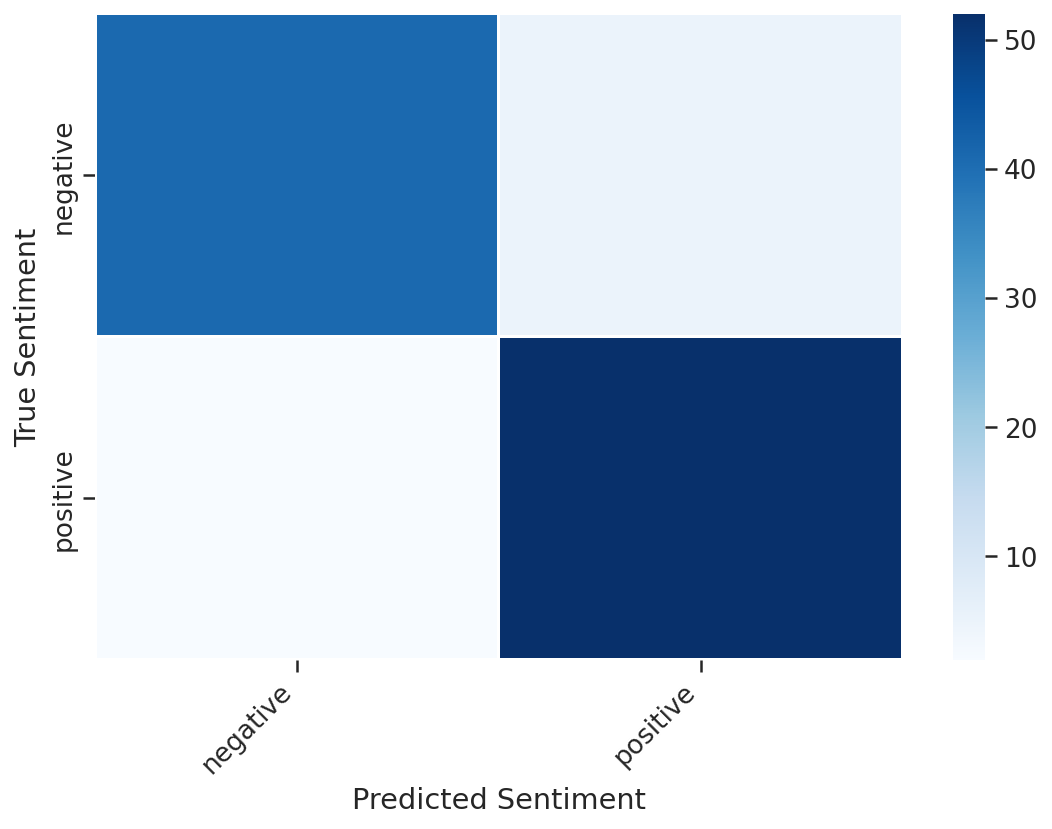

In [ ]:
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Blues')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct sentiment for each review. 